# Machine Learning for Complete Intersection Calabi-Yau Manifolds

We use a machine learning (ML) approach predict the **Hodge numbers** $h_{11}$ and $h_{21}$ of **Calabi-Yau** (CY) 3-folds in the framework of **String Theory**. First of all we analyse the dataset of the manifolds and build a consistent preanalysis to visualise the distribution of the data and extract the necessary features. We will first plot different distributions of the data and performed unsupervised tasks to find structures in them (in particular we use **clustering** and **principal components analysis**). We then study the **variable ranking** of the features and try to figure out the "good" features we can use in the real analysis.

## Infrastructure

We print information about the current OS:

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

Current OS:                  Linux (kernel release: 5.6.6-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       3401 MHz (max: 3800 MHz)
Available RAM memory:        9843 MB (tot: 15758 MB)


For future use, we establish early in the notebook the number of maximum jobs that every algorithm can take concurrently. Thus, if we want to run parallel notebooks with different jobs, we will not encounter issues.

In [2]:
n_jobs = int(InfoOS().threads / 2)

We then print information on the current GPU setup (if available):

In [3]:
!nvidia-smi

Fri Apr 24 17:12:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   39C    P8    N/A /  N/A |     37MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Setup

We import the Python modules we use and print their versions to keep track of changes.

In [4]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import backend as K

import warnings
warnings.simplefilter(action='ignore', category=UserWarning) # ignore user warnings: nothing that I can really do anything about it...


%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))
print('Scikit-optimize version: {}'    .format(sko.__version__))
print('Tensorflow version: {}'         .format(tf.__version__))
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.1
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Scikit-optimize version: 0.7.4
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)


## Session Preparation

In order to save the results of the analysis, we define where to store images, log files and models:

In [5]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs

DB_NAME = 'cicy3o' #---------------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.h5' #--------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' #--- subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)

We also create a log file to store debug and related information:

In [6]:
import logging

from mltools.liblog import create_logfile

path_to_log = path.join(LOG_PATH,
                        DB_NAME + '_preanalysis.log'
                       )
log = create_logfile(path_to_log,
                     name=DB_NAME + '_preanalysis',
                     level=logging.DEBUG
                    )

# these lines provide the same setup also for the Jupyter logging
logger = logging.getLogger() #------------------------------------------------- get the current logging session

fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s') #-------- customise the formatting options

handler = logging.StreamHandler() #-------------------------------------------- handle the stream to the default (stderr)
handler.setLevel(logging.DEBUG) #---------------------------------------------- print everything
handler.setFormatter(fmt) #---------------------------------------------------- set the formatting options

logger.handlers = [handler] #-------------------------------------------------- override the default stream

# we are ready to go!
log.info('New logging session started. Log is at {}.'.format(path_to_log))

Rotating existing logs...


2020-04-24 17:12:51,359: INFO ==> New logging session started. Log is at ./log/original/cicy3o_preanalysis.log.


We finally set the _memory growth_ property of the GPU in order to avoid overflowing its RAM memory:

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------------------------------- list of physical GPUs

if gpus: #----------------------------------------------------------------------------------------- set memory growth only if GPU is active
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------------------------------- set memory growth
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') #------------------------ list of logical devices
        print('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus),
                                                                         len(logical_gpus)
                                                                        )
             )
    except RuntimeError as e:
        print(e)
else:
    print('No GPUs in the setup!')

GPU setup: 1 physical GPUs, 1 logical GPUs.


## Fetch Dataset

We then fetch the dataset from its location at http://www.lpthe.jussieu.fr/~erbin/files/data/.

In [8]:
import tarfile

from os     import remove
from urllib import request as rq

URL_ROOT = 'http://www.lpthe.jussieu.fr/~erbin/files/data/' #------------------------- root of the URL
TAR_FILE = DB_NAME + '_data.tar.gz' #------------------------------------------------- name of the tarball located at the URL
TAR_PATH = path.join(ROOT_DIR, TAR_FILE) #-------------------------------------------- path of the tarball in the local system

def extract_tar(tarname, dbfile, root):
    '''
    Extract database from tarball in the root directory.
    
    Required arguments:
        tarname: the tarball file,
        dbfile:  the name of the file to extract,
        root:    where to extract the file.
    '''
    with tarfile.open(tarname, 'r') as tar:
        tar.extract(dbfile, path=root)
    
if not path.isfile(DB_PATH): #-------------------------------------------------------- check if the dataset is already present locally
    if not path.isfile(TAR_PATH): #--------------------------------------------------- check if the tarball is already present locally
        _, message = rq.urlretrieve(URL_ROOT + TAR_FILE, TAR_PATH) #------------------ download the file
        log.debug('Remote file saved in {}.'.format(TAR_PATH))
        
        extract_tar(TAR_PATH, DB_FILE, ROOT_DIR) #------------------------------------ extract the dataset
        remove(TAR_PATH) #------------------------------------------------------------ remove tarball
        log.debug('Dataset saved in {}'.format(DB_PATH))
    else:
        extract_tar(TAR_PATH, DB_FILE, ROOT_DIR) #------------------------------------ extract the dataset
        remove(TAR_PATH) #------------------------------------------------------------ remove tarball
        log.debug('Dataset saved in {}'.format(DB_PATH))
else:
    log.debug('Dataset already dowloaded in {}.'.format(DB_PATH))

2020-04-24 17:12:51,538: DEBUG ==> Dataset already dowloaded in ./cicy3o.h5.


## Preanalysis

We use [Scikit-learn](https://scikit-learn.org/stable/index.html) as **Python** library for the preanalysis and [Matplotlib](https://matplotlib.org/) to plot the results.

### Loading the Dataset

We first load and select the entries of the dataset which we use during the analysis.

In [9]:
import pandas as pd

# load the dataset
if path.isfile(DB_PATH):
    df = pd.read_hdf(DB_PATH)
    log.debug('Database loaded.')
    log.info('Shape is {:d} rows x {:d} columns.'.format(df.shape[0], df.shape[1]))
else:
    log.error('Cannot load database from {}!'.format(DB_PATH))

2020-04-24 17:12:51,848: DEBUG ==> Database loaded.
2020-04-24 17:12:51,848: INFO ==> Shape is 7890 rows x 31 columns.


We then print a few statistics of the current dataset:

In [10]:
df.describe()

,euler,h11,h21,num_cp,num_eqs,min_dim_cp,max_dim_cp,mean_dim_cp,median_dim_cp,num_cp_1,...,num_over,num_ex,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,rank_matrix,norm_matrix,isprod,favour
count,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,...,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.0
mean,-42.649937,7.419772,28.744740,6.540684,7.301648,1.020152,2.708999,1.616977,1.409252,3.572750,...,3.760963,2.239037,2.027503,3.277186,2.378916,2.172687,6.216857,4.242878,0.002788,0.0
std,20.589891,2.250891,8.577282,1.596812,2.087152,0.184930,0.791630,0.296287,0.482226,1.442995,...,1.163259,1.163259,0.212140,0.651334,0.334796,0.407180,1.723061,0.333623,0.052734,0.0
min,-200.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,0.000000,0.0
25%,-52.000000,6.000000,23.000000,5.000000,6.000000,1.000000,2.000000,1.428571,1.000000,3.000000,...,3.000000,1.000000,2.000000,3.000000,2.166667,2.000000,5.000000,4.000000,0.000000,0.0
50%,-40.000000,7.000000,27.000000,7.000000,7.000000,1.000000,3.000000,1.571429,1.000000,4.000000,...,4.000000,2.000000,2.000000,3.000000,2.285714,2.000000,6.000000,4.242641,0.000000,0.0
75%,-28.000000,9.000000,33.000000,8.000000,9.000000,1.000000,3.000000,1.714286,2.000000,5.000000,...,5.000000,3.000000,2.000000,4.000000,2.500000,2.000000,7.000000,4.472136,0.000000,0.0
max,0.000000,19.000000,101.000000,12.000000,15.000000,7.000000,7.000000,7.000000,7.000000,9.000000,...,6.000000,6.000000,8.000000,8.000000,8.000000,8.000000,12.000000,5.477226,1.000000,0.0


As well as the `dtypes` of the columns since they will be relevant for the subsequent analysis:

In [11]:
df.dtypes

c2                 object
euler               int16
h11                 int16
h21                 int16
matrix             object
redun              object
size               object
num_cp               int8
num_eqs             int64
dim_cp             object
min_dim_cp          int64
max_dim_cp          int64
mean_dim_cp       float64
median_dim_cp     float64
num_dim_cp         object
num_cp_1             int8
num_cp_2             int8
num_cp_neq1          int8
num_over             int8
num_ex               int8
deg_eqs            object
min_deg_eqs         int64
max_deg_eqs         int64
mean_deg_eqs      float64
median_deg_eqs    float64
num_deg_eqs        object
rank_matrix          int8
norm_matrix       float64
dim_h0_amb         object
isprod              int64
favour              int64
dtype: object

We then focus only on manifolds which **are not** direct products of spaces, that is we keep only `isprod = 0`:

In [12]:
# take only isprod = 0 and remove the corresponding column
df_noprod = df.loc[df['isprod'] == 0].drop(columns=['isprod'])
log.debug('Database reshaped to {:d} rows x {:d} columns.'.format(df_noprod.shape[0], df_noprod.shape[1]))

2020-04-24 17:12:51,966: DEBUG ==> Database reshaped to 7868 rows x 30 columns.


We can then visualise the distribution of the labels $h_{11}$ and $h_{21}$:

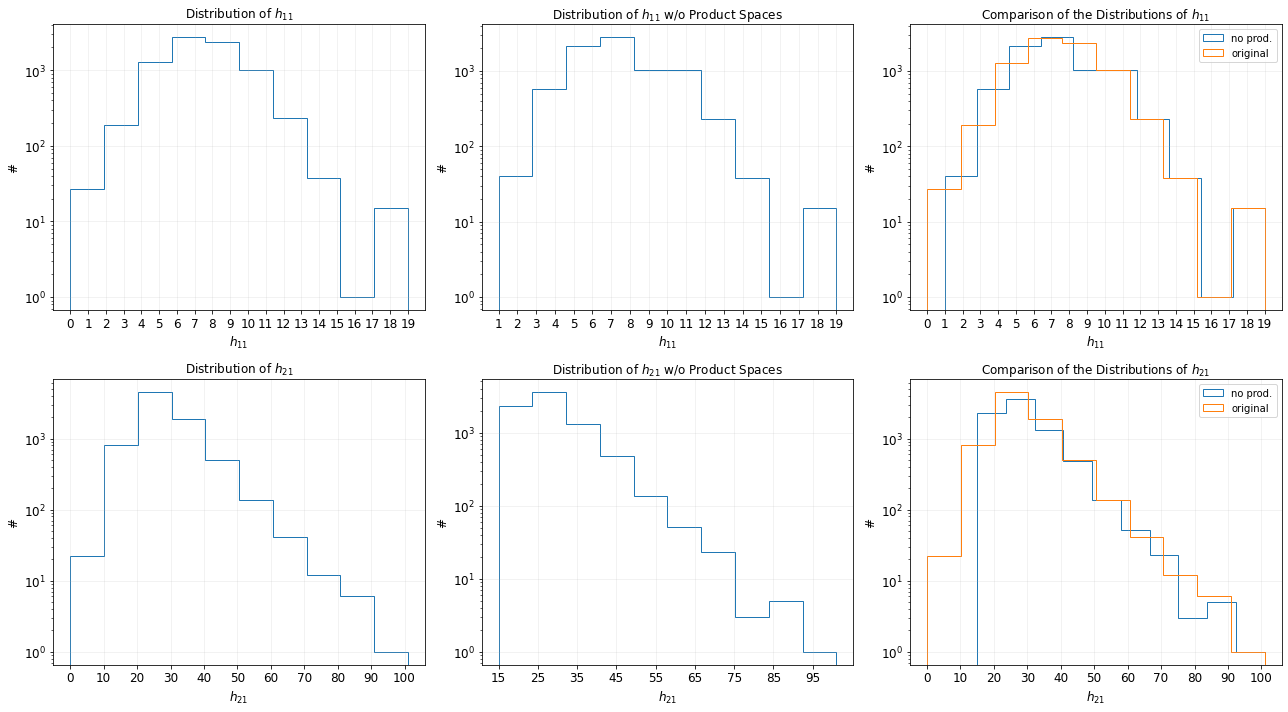

2020-04-24 17:12:54,586: DEBUG ==> Plot saved to ./img/original/labels_distribution.pdf.


In [13]:
from mltools.libplot import Plot

plot = Plot(rows=2, columns=3)

plot.hist2D(df['h11'],        axis=(0,0), title='Distribution of $h_{11}$',                    xlabel='$h_{11}$', ylabel='#', ylog=True)
plot.hist2D(df_noprod['h11'], axis=(0,1), title='Distribution of $h_{11}$ w/o Product Spaces', xlabel='$h_{11}$', ylabel='#', ylog=True)
plot.hist2D(df_noprod['h11'], axis=(0,2), title='Comparison of the Distributions of $h_{11}$', xlabel='$h_{11}$', ylabel='#', ylog=True, legend='no prod.')
plot.hist2D(df['h11'],        axis=(0,2), title='Comparison of the Distributions of $h_{11}$', xlabel='$h_{11}$', ylabel='#', ylog=True, legend='original')

plot.hist2D(df['h21'],        axis=(1,0), title='Distribution of $h_{21}$',                    xlabel='$h_{21}$', ylabel='#', ylog=True, binstep=10)
plot.hist2D(df_noprod['h21'], axis=(1,1), title='Distribution of $h_{21}$ w/o Product Spaces', xlabel='$h_{21}$', ylabel='#', ylog=True, binstep=10)
plot.hist2D(df_noprod['h21'], axis=(1,2), title='Comparison of the Distributions of $h_{21}$', xlabel='$h_{21}$', ylabel='#', ylog=True, legend='no prod.', binstep=10)
plot.hist2D(df['h21'],        axis=(1,2), title='Comparison of the Distributions of $h_{21}$', xlabel='$h_{21}$', ylabel='#', ylog=True, legend='original', binstep=10)

plot.save_and_close(path.join(IMG_PATH, 'labels_distribution'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'labels_distribution.pdf')))

### Remove the Outliers

In order to improve the training of the algorithms, we then remove the outliers of the distributions. We keep $h_{11} \in \left[ 1, 16 \right]$ and $h_{21} \in \left[ 1, 86 \right]$:

In [14]:
from mltools.libtransformer import RemoveOutliers

filter_dict = {'h11': [1, 16],
               'h21': [1, 86]
              }

df_noprod_noout = RemoveOutliers(filter_dict=filter_dict).fit_transform(df_noprod)
log.debug('Database reshaped to {:d} rows x {:d} columns.'.format(df_noprod_noout.shape[0], df_noprod_noout.shape[1]))

2020-04-24 17:12:54,626: DEBUG ==> Database reshaped to 7851 rows x 30 columns.


We then show the distribution of the newly extracted dataset in comparison with the previous versions:

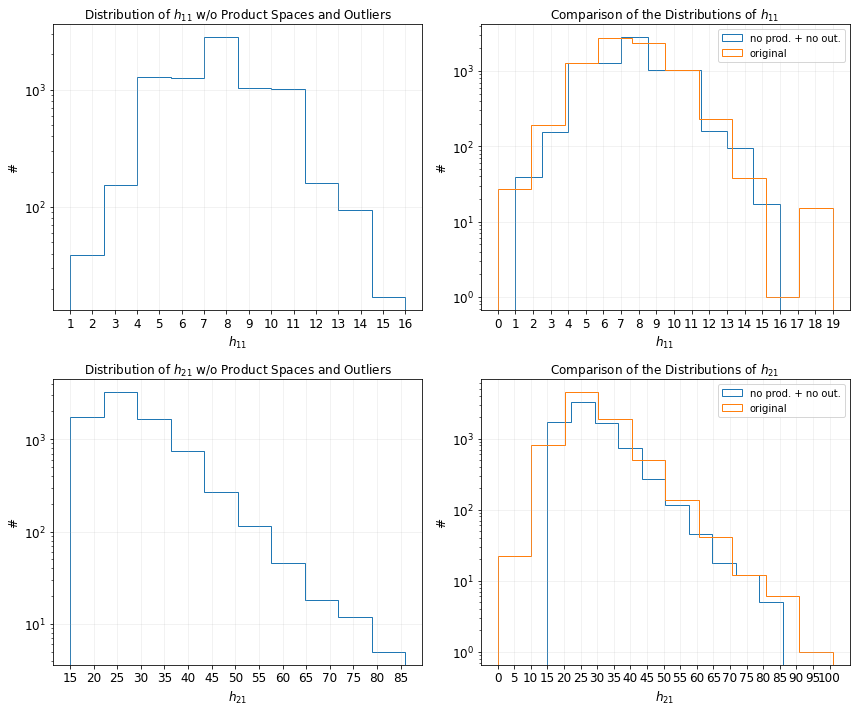

2020-04-24 17:12:56,157: DEBUG ==> Plot saved to ./img/original/labels_distribution_noouts.pdf.


In [15]:
plot = Plot(rows=2, columns=2)

plot.hist2D(df_noprod_noout['h11'], axis=(0,0), title='Distribution of $h_{11}$ w/o Product Spaces and Outliers', xlabel='$h_{11}$', ylabel='#', ylog=True)
plot.hist2D(df_noprod_noout['h11'], axis=(0,1), title='Comparison of the Distributions of $h_{11}$',              xlabel='$h_{11}$', ylabel='#', ylog=True, legend='no prod. + no out.')
plot.hist2D(df['h11'],              axis=(0,1), title='Comparison of the Distributions of $h_{11}$',              xlabel='$h_{11}$', ylabel='#', ylog=True, legend='original')

plot.hist2D(df_noprod_noout['h21'], axis=(1,0), title='Distribution of $h_{21}$ w/o Product Spaces and Outliers', xlabel='$h_{21}$', ylabel='#', ylog=True, binstep=5)
plot.hist2D(df_noprod_noout['h21'], axis=(1,1), title='Comparison of the Distributions of $h_{21}$',              xlabel='$h_{21}$', ylabel='#', ylog=True, legend='no prod. + no out.', binstep=5)
plot.hist2D(df['h21'],              axis=(1,1), title='Comparison of the Distributions of $h_{21}$',              xlabel='$h_{21}$', ylabel='#', ylog=True, legend='original', binstep=5)

plot.save_and_close(path.join(IMG_PATH, 'labels_distribution_noout'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'labels_distribution_noouts.pdf')))

### Data Visualisation

We can then move to the visualisation of the distribution of the labels as a function of several features (mainly scalars for visualisation reasons). In particular we first consider the scatter plot of $h_{11}$ and $h_{21}$ as functions of the **scalar** features and the **correlation matrix** of them, before moving to computing the **principal component analysis** (PCA) in 2D to plot the configuration matrix.

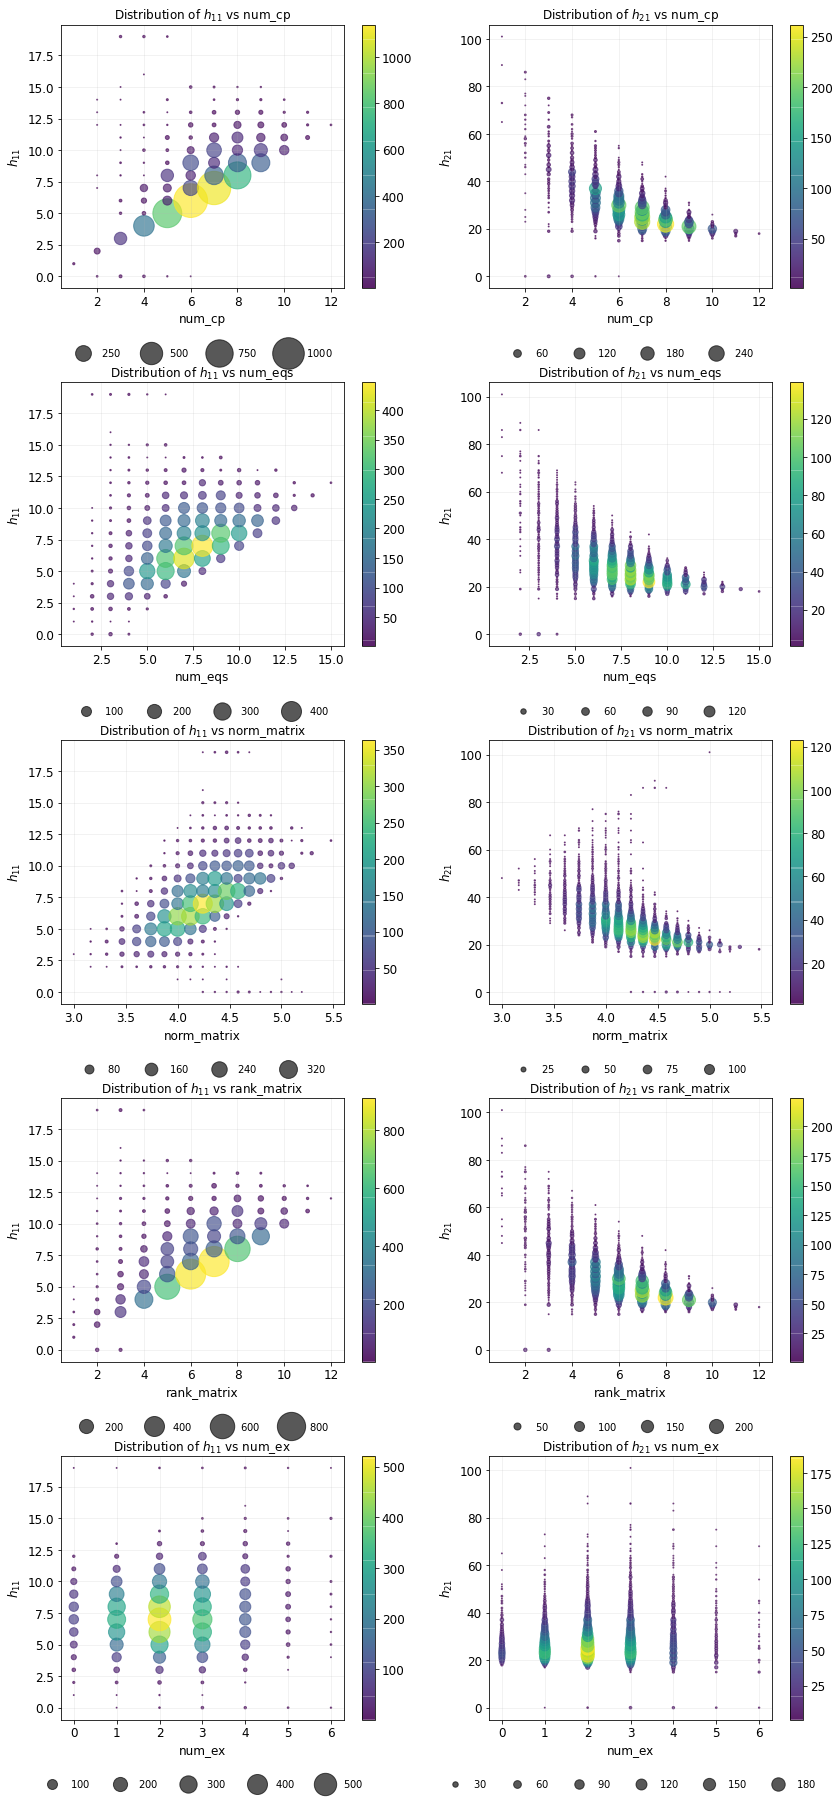

2020-04-24 17:12:59,945: DEBUG ==> Plot saved to ./img/original/scalar_features_distribution.pdf.


In [16]:
def get_counts(df, label, feature):
    '''
    Generator to produce the count of unique occurrencies of the data.
    
    Required arguments:
        df:      the Pandas dataframe
        label:   the label to consider
        feature: the feature to consider
        
    Yields:
        np.array([ unique feature, unique value, counts ])
    '''

    for n in np.sort(df[feature].unique()):
        uniques, counts = np.unique(df[label].loc[df[feature] == n].values,
                                    return_counts=True)
        
        for u, c in np.c_[uniques, counts]:
            yield np.array([ n, u, c ])

plot = Plot(rows=5, columns=2)

plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'num_cp'))).T,
               axis=(0,0),
               title='Distribution of $h_{11}$ vs num_cp',
               xlabel='num_cp',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'num_eqs'))).T,
               axis=(1,0),
               title='Distribution of $h_{11}$ vs num_eqs',
               xlabel='num_eqs',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'norm_matrix'))).T,
               axis=(2,0),
               title='Distribution of $h_{11}$ vs norm_matrix',
               xlabel='norm_matrix',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'rank_matrix'))).T,
               axis=(3,0),
               title='Distribution of $h_{11}$ vs rank_matrix',
               xlabel='rank_matrix',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'num_ex'))).T,
               axis=(4,0),
               title='Distribution of $h_{11}$ vs num_ex',
               xlabel='num_ex',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.65
              )

plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'num_cp'))).T,
               
               axis=(0,1),
               title='Distribution of $h_{21}$ vs num_cp',
               xlabel='num_cp',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'num_eqs'))).T,
               axis=(1,1),
               title='Distribution of $h_{21}$ vs num_eqs',
               xlabel='num_eqs',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'norm_matrix'))).T,
               axis=(2,1),
               title='Distribution of $h_{21}$ vs norm_matrix',
               xlabel='norm_matrix',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'rank_matrix'))).T,
               axis=(3,1),
               title='Distribution of $h_{21}$ vs rank_matrix',
               xlabel='rank_matrix',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.65
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'num_ex'))).T,
               axis=(4,1),
               title='Distribution of $h_{21}$ vs num_ex',
               xlabel='num_ex',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.65
              )

plot.save_and_close(path.join(IMG_PATH, 'scalar_features_distribution'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'scalar_features_distribution.pdf')))

### Correlation Matrix

We then compute the correlation matrix of the scalar features:

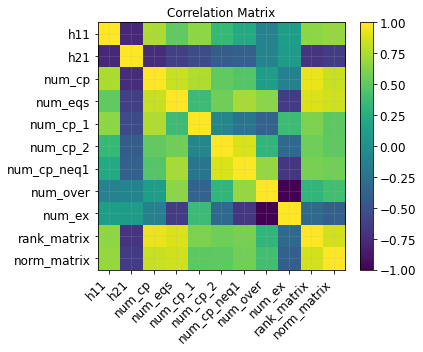

2020-04-24 17:13:00,249: DEBUG ==> Plot saved to ./img/original/correlation_matrix.pdf.


In [17]:
corr = df_noprod_noout[['h11', 'h21', 'num_cp', 'num_eqs', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'rank_matrix', 'norm_matrix']].corr()

Plot().matrix(data=corr, title='Correlation Matrix', xticks=corr.columns, yticks=corr.columns).save_and_close(path.join(IMG_PATH, 'correlation_matrix'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'correlation_matrix.pdf')))

### Shuffling the Samples

We then shuffle the database to avoid inserting ordering bias in clustering and PCA. In principle there tons of ways to do it, but we choose the _Pandas_ way: using the function `sample` we return 100% of the database (`frac=1`) in random order (use `random_state` for consistency between runs).

In [18]:
df_shuffled = df_noprod_noout.sample(frac=1, random_state=RAND) #---- get 100% of the dataset in random order
log.debug('Dataframe shuffled with random state {:d}.'.format(RAND))

2020-04-24 17:13:00,261: DEBUG ==> Dataframe shuffled with random state 42.


### K Means Clustering

We then compute the **K Means** clustering labels for the matrix components to find structure in the data and be able to improve the training algorithms. This is an **unsupervised** preanalyisis: in this particular case we do not need to divide the dataset into training and validation sets, however it is best to shuffle the dataset.

In [19]:
from mltools.libtransformer import ExtractTensor

# flatten the matrix to use in clustering and 
matrix = np.array(ExtractTensor(flatten=True).fit_transform(df_shuffled['matrix']))

Then we proceed with the clustering analysis:

In [20]:
from sklearn.cluster import KMeans

clusters      = range(2,16) #------------------------------------------------ study clusters in range [2, 15]
kmeans_labels = np.zeros((np.shape(matrix)[0], np.shape(clusters)[0])) #----- shape: n_samples x n_clusters (store the labels)

for n in clusters:
    kmeans_labels[:,n-clusters.start] = KMeans(n_clusters=n,
                                               n_jobs=n_jobs,
                                               random_state=RAND
                                              ).fit_predict(matrix)
    log.info('Computed K Means with {:d} clusters.'.format(n))

2020-04-24 17:13:01,920: INFO ==> Computed K Means with 2 clusters.
2020-04-24 17:13:02,553: INFO ==> Computed K Means with 3 clusters.
2020-04-24 17:13:03,267: INFO ==> Computed K Means with 4 clusters.
2020-04-24 17:13:04,298: INFO ==> Computed K Means with 5 clusters.
2020-04-24 17:13:05,365: INFO ==> Computed K Means with 6 clusters.
2020-04-24 17:13:06,449: INFO ==> Computed K Means with 7 clusters.
2020-04-24 17:13:07,756: INFO ==> Computed K Means with 8 clusters.
2020-04-24 17:13:09,192: INFO ==> Computed K Means with 9 clusters.
2020-04-24 17:13:10,698: INFO ==> Computed K Means with 10 clusters.
2020-04-24 17:13:12,415: INFO ==> Computed K Means with 11 clusters.
2020-04-24 17:13:13,883: INFO ==> Computed K Means with 12 clusters.
2020-04-24 17:13:15,459: INFO ==> Computed K Means with 13 clusters.
2020-04-24 17:13:17,258: INFO ==> Computed K Means with 14 clusters.
2020-04-24 17:13:19,153: INFO ==> Computed K Means with 15 clusters.


The distribution of the clustering labels can be visualised in a scatter plot. We pick some values of the number of clusters and show the ripartition of the labels using a different colour code for each of them.

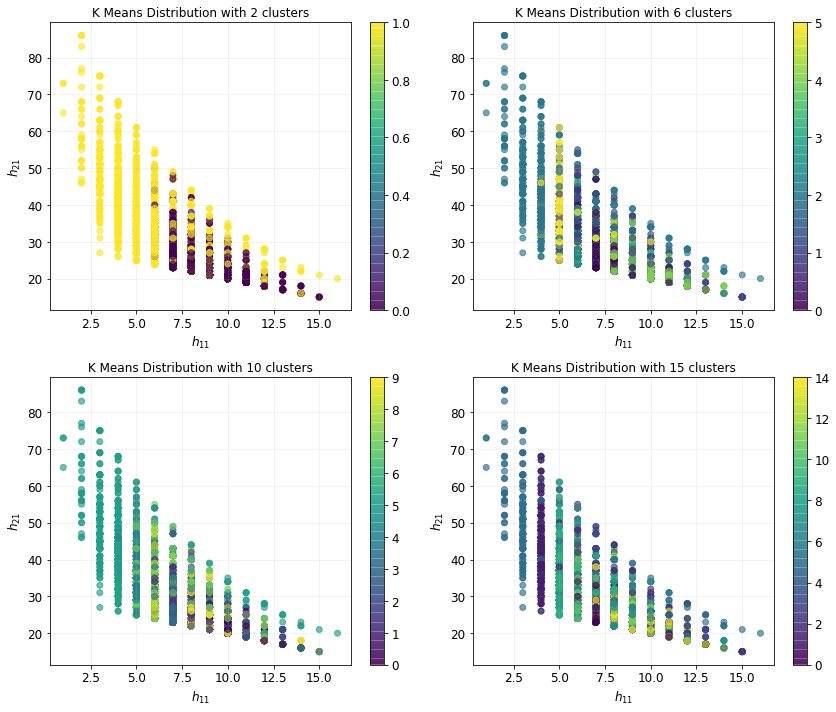

2020-04-24 17:13:23,943: DEBUG ==> Plot saved to ./img/original/cluster_distribution.pdf.


In [21]:
plot = Plot(rows=2, columns=2)

plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,0]],
               axis=(0,0),
               title='K Means Distribution with 2 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True,
               alpha=0.65
              )
plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,4]],
               axis=(0,1),
               title='K Means Distribution with 6 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True,
               alpha=0.65
              )
plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,8]],
               axis=(1,0),
               title='K Means Distribution with 10 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True,
               alpha=0.65
              )
plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,13]],
               axis=(1,1),
               title='K Means Distribution with 15 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True,
               alpha=0.65
              )

plot.save_and_close(path.join(IMG_PATH, 'cluster_distribution'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'cluster_distribution.pdf')))

### PCA

We then proceed with the **PCA** analysis with a twofold purpose: we first compute the 2 principal components of the **configuration matrix** to be able to plot the distribution of the matrix entries in a 2D plot, we then compute the PCA with **99% of the variance** retained.

2020-04-24 17:13:24,018: INFO ==> PCA variance retained for each component: [0.09086901 0.05593708]


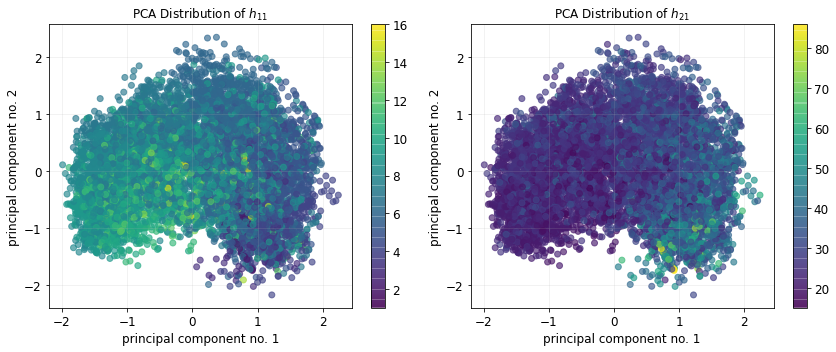

2020-04-24 17:13:26,500: DEBUG ==> Plot saved to ./img/original/pca_distribution.pdf.


In [22]:
from sklearn.decomposition import PCA

pca2D_transformer = PCA(n_components=2, random_state=RAND)
pca2D = pca2D_transformer.fit_transform(matrix)
log.info('PCA variance retained for each component: {}'.format(pca2D_transformer.explained_variance_ratio_))

pca2D_plot_h11 = np.array([pca2D[:,0], pca2D[:,1], df_shuffled['h11'].values])
pca2D_plot_h21 = np.array([pca2D[:,0], pca2D[:,1], df_shuffled['h21'].values])

plot = Plot(rows=1, columns=2)

plot.scatter2D(data=pca2D_plot_h11,
               axis=0,
               title='PCA Distribution of $h_{11}$',
               xlabel='principal component no. 1',
               ylabel='principal component no. 2',
               size=False,
               alpha=0.65
              )
plot.scatter2D(data=pca2D_plot_h21,
               axis=1,
               title='PCA Distribution of $h_{21}$',
               xlabel='principal component no. 1',
               ylabel='principal component no. 2',
               size=False,
               alpha=0.65
              )

plot.save_and_close(path.join(IMG_PATH, 'pca_distribution'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'pca_distribution.pdf')))

We then compute the PCA with **99% of variance** retained (this is the PCA which will end up in the final analysis):

In [23]:
pca99 = PCA(n_components=0.99, random_state=RAND).fit_transform(matrix)
log.info('PCA principal components: {:d}'.format(np.shape(pca99)[1]))

2020-04-24 17:13:26,859: INFO ==> PCA principal components: 81


### Variable Ranking

We now select the features we are interested in ranking in order to select only those which can actually contribute to the prediction of $h_{11}$ and $h_{21}$. We divide them into **scalar**, **vector** and **tensor** (matrix) features and extract them from the dataset (we do not use them all: we avoid columns with _mean_, _max_, _min_ (_et similia_) in the name since they can be easily extracted from other features.

In [24]:
scalars = ['num_cp', 'num_eqs', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'rank_matrix', 'norm_matrix']
vectors = ['dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs', 'dim_h0_amb']

We now build a matrix to hold each entry of the dataset in rows and each feature in columns. We start from the scalars and then we add the vectors after the extraction from the sparse format in which they are currently stored.

In [25]:
ranking_features = np.zeros((np.shape(df_shuffled)[0], np.shape(scalars)[0]), dtype=np.float) #---- shape: n_samples x n_scalar_features
ranking_lengths  = np.ones(np.shape(scalars)[0], dtype=np.int) #----------------------------------- shape: 1 x n_scalar_features

for n in range(np.shape(scalars)[0]):
    ranking_features[:,n] = ExtractTensor(flatten=True).fit_transform(df_shuffled[scalars[n]]) #--- put features in columns (samples in rows)

We can now extract the vector features from the dataset:

In [26]:
for feature in vectors:
    vector           = ExtractTensor(flatten=True).fit_transform(df_shuffled[feature]) #---- extract the feature
    ranking_features = np.c_[ranking_features, vector] #------------------------------------ concatenate (put another column to ranking_features)
    ranking_lengths  = np.append(ranking_lengths, np.shape(vector)[1]) #-------------------- append length to vector of lengths

We now proceed to the variable ranking in two ways:

1. using `ranking_features`, `kmeans_labels` and `matrix`
2. using `ranking_features`, `kmeans_labels` and `pca99`

to avoid redundancies in the computation. We use a **Random Forest** algorithm in the _Scikit_ implementation. At this stage we are not interested in predictions, thus it is not necessary to fine tune the algorithm. Being the random forest and ensemble estimator, we use a reasonable amount of base estimators and do not worry too much about overfitting the set.

In [27]:
from sklearn.ensemble import RandomForestRegressor
from mltools.libscore import Score

rnd_for = RandomForestRegressor(n_estimators=100, # 100 trees in the forest is reasonably fast to pull off
                                random_state=RAND,
                                n_jobs=n_jobs
                               )

We now start from the first variable ranking (with the configuration matrix):

In [28]:
features = np.c_[ranking_features,
                 kmeans_labels,
                 matrix] #------------------------------------------------------------------------- build the feature vector

#############################
#                           #
# LABEL LIST                #
#                           #
#############################
ranking_labels = [] #------------------------------------------------------------------------------ initialise label list
for n in range(np.shape(scalars + vectors)[0]):
    ranking_labels.append((scalars + vectors)[n]) #------------------------------------------------ add feature label
    for _ in range(ranking_lengths[n]-1):
        ranking_labels.append('') #---------------------------------------------------------------- add empty separator for each entry after the first
    
for n in range(np.shape(kmeans_labels)[1]):
    ranking_labels.append('{:d} clusters'.format(n + clusters.start)) #---------------------------- add clustering labels
    
ranking_labels.append('matrix') #------------------------------------------------------------------ add matrix label
for _ in range(np.shape(matrix)[1]-1):
    ranking_labels.append('') #-------------------------------------------------------------------- add empty separator for each entry after the first

#############################
#                           #
# RANDOM FOREST FIT         #
#                           #
#############################
rnd_for.fit(X=features,
            y=df_shuffled['h11'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h11
score = Score(y_true=df_shuffled['h11'].values,
              y_pred=rnd_for.predict(features),
              rounding=np.floor
             ) #----------------------------------------------------------------------------------- get training score for debug purposes
log.info('Accuracy of ranking (with matrix) on h11: {:.3f}%'.format(score.accuracy()*100)) #------- get training accuracy

importances_mat_h11 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h11

rnd_for.fit(X=features,
            y=df_shuffled['h21'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h21
score = Score(y_true=df_shuffled['h21'].values,
              y_pred=rnd_for.predict(features),
              rounding=np.floor
             ) #----------------------------------------------------------------------------------- get training score for debug purposes
log.info('Accuracy of ranking (with matrix) on h21: {:.3f}%'.format(score.accuracy()*100)) #------- get training accuracy

importances_mat_h21 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h21

2020-04-24 17:13:31,335: INFO ==> Accuracy of ranking (with matrix) on h11: 74.627%
2020-04-24 17:13:34,948: INFO ==> Accuracy of ranking (with matrix) on h21: 43.485%


We then compute the same with the PCA components:

In [29]:
features = np.c_[ranking_features,
                 kmeans_labels,
                 pca99] #-------------------------------------------------------------------------- build the feature vector

#############################
#                           #
# LABEL LIST                #
#                           #
#############################
ranking_labels = [] #------------------------------------------------------------------------------ initialise label list
for n in range(np.shape(scalars + vectors)[0]):
    ranking_labels.append((scalars + vectors)[n]) #------------------------------------------------ add feature label
    for _ in range(ranking_lengths[n]-1):
        ranking_labels.append('') #---------------------------------------------------------------- add empty separator for each entry after the first
    
for n in range(np.shape(kmeans_labels)[1]):
    ranking_labels.append('{:d} clusters'.format(n + clusters.start)) #---------------------------- add clustering labels
    
ranking_labels.append('pca') #--------------------------------------------------------------------- add matrix label
for _ in range(np.shape(pca99)[1]-1):
    ranking_labels.append('') #-------------------------------------------------------------------- add empty separator for each entry after the first

#############################
#                           #
# RANDOM FOREST FIT         #
#                           #
#############################
rnd_for.fit(X=features,
            y=df_shuffled['h11'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h11
score = Score(y_true=df_shuffled['h11'].values,
              y_pred=rnd_for.predict(features),
              rounding=np.floor
             ) #----------------------------------------------------------------------------------- get training score for debug purposes
log.info('Accuracy of ranking (with PCA) on h11: {:.3f}%'.format(score.accuracy()*100)) #---------- get training accuracy

importances_pca_h11 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h11

rnd_for.fit(X=features,
            y=df_shuffled['h21'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h21
score = Score(y_true=df_shuffled['h21'].values,
              y_pred=rnd_for.predict(features),
              rounding=np.floor
             ) #----------------------------------------------------------------------------------- get training score for debug purposes
log.info('Accuracy of ranking (with PCA) on h21: {:.3f}%'.format(score.accuracy()*100)) #---------- get training accuracy

importances_pca_h21 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h21

2020-04-24 17:13:48,439: INFO ==> Accuracy of ranking (with PCA) on h11: 71.316%
2020-04-24 17:14:01,921: INFO ==> Accuracy of ranking (with PCA) on h21: 41.689%


#### Separate Feature Visualisation

We then proceed with the visualisation of the feature importances. We first consider the various features separately: we plot each scalar, vector and tensor feature with the importance of each of their components. We also show the difference between the variable ranking with the matrix and the PCA by plotting the results in two side-by-side columns.

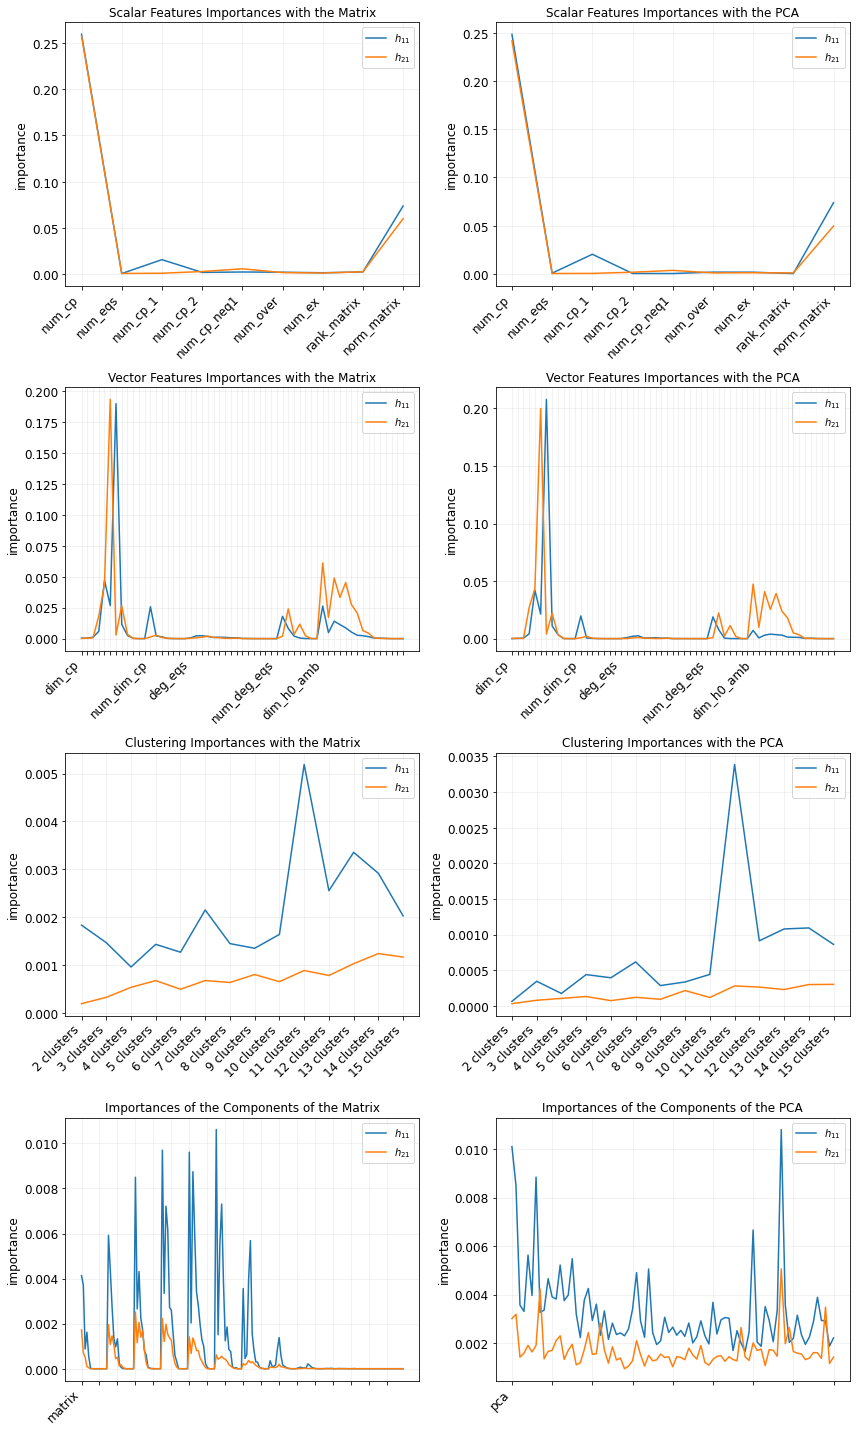

2020-04-24 17:14:03,794: DEBUG ==> Plot saved to ./img/original/feature_importances.pdf.


In [30]:
# define the data for the plots
scalars_mat_lab  = [i[0] for i in importances_mat_h11[0:np.shape(scalars)[0]]]
scalars_mat_h11  = [i[1] for i in importances_mat_h11[0:np.shape(scalars)[0]]]
scalars_mat_h21  = [i[1] for i in importances_mat_h21[0:np.shape(scalars)[0]]] #------------------------- scalar features with the matrix

scalars_pca_lab  = [i[0] for i in importances_pca_h11[0:np.shape(scalars)[0]]]
scalars_pca_h11  = [i[1] for i in importances_pca_h11[0:np.shape(scalars)[0]]]
scalars_pca_h21  = [i[1] for i in importances_pca_h21[0:np.shape(scalars)[0]]] #------------------------- scalar features with the pca

vector_index     = np.shape(scalars)[0] + np.sum(ranking_lengths[np.shape(scalars)[0]:])
vectors_mat_lab  = [i[0] for i in importances_mat_h11[np.shape(scalars)[0]:vector_index]]
vectors_mat_h11  = [i[1] for i in importances_mat_h11[np.shape(scalars)[0]:vector_index]]
vectors_mat_h21  = [i[1] for i in importances_mat_h21[np.shape(scalars)[0]:vector_index]] #-------------- vector features with the matrix

vectors_pca_lab  = [i[0] for i in importances_pca_h11[np.shape(scalars)[0]:vector_index]]
vectors_pca_h11  = [i[1] for i in importances_pca_h11[np.shape(scalars)[0]:vector_index]]
vectors_pca_h21  = [i[1] for i in importances_pca_h21[np.shape(scalars)[0]:vector_index]] #-------------- vector features with the pca

cluster_index    = vector_index + np.shape(kmeans_labels)[1]
clusters_mat_lab = [i[0] for i in importances_mat_h11[vector_index:cluster_index]]
clusters_mat_h11 = [i[1] for i in importances_mat_h11[vector_index:cluster_index]]
clusters_mat_h21 = [i[1] for i in importances_mat_h21[vector_index:cluster_index]] #--------------------- cluster ranking with the matrix

clusters_pca_lab = [i[0] for i in importances_pca_h11[vector_index:cluster_index]]
clusters_pca_h11 = [i[1] for i in importances_pca_h11[vector_index:cluster_index]]
clusters_pca_h21 = [i[1] for i in importances_pca_h21[vector_index:cluster_index]] #--------------------- cluster ranking with the pca

mat_lab          = [i[0] for i in importances_mat_h11[cluster_index:]]
mat_h11          = [i[1] for i in importances_mat_h11[cluster_index:]]
mat_h21          = [i[1] for i in importances_mat_h21[cluster_index:]] #--------------------------------- matrix importances

pca_lab          = [i[0] for i in importances_pca_h11[cluster_index:]]
pca_h11          = [i[1] for i in importances_pca_h11[cluster_index:]]
pca_h21          = [i[1] for i in importances_pca_h21[cluster_index:]] #--------------------------------- pca importances


# plot the results
plot = Plot(rows=4, columns=2)

plot.series2D(data=scalars_mat_h11,  axis=(0,0), title='Scalar Features Importances with the Matrix', ylabel='importance', legend='$h_{11}$', labels=scalars_mat_lab)
plot.series2D(data=scalars_mat_h21,  axis=(0,0), title='Scalar Features Importances with the Matrix', ylabel='importance', legend='$h_{21}$', labels=scalars_mat_lab)
plot.series2D(data=scalars_pca_h11,  axis=(0,1), title='Scalar Features Importances with the PCA',    ylabel='importance', legend='$h_{11}$', labels=scalars_pca_lab)
plot.series2D(data=scalars_pca_h21,  axis=(0,1), title='Scalar Features Importances with the PCA',    ylabel='importance', legend='$h_{21}$', labels=scalars_pca_lab)

plot.series2D(data=vectors_mat_h11,  axis=(1,0), title='Vector Features Importances with the Matrix', ylabel='importance', legend='$h_{11}$', labels=vectors_mat_lab)
plot.series2D(data=vectors_mat_h21,  axis=(1,0), title='Vector Features Importances with the Matrix', ylabel='importance', legend='$h_{21}$', labels=vectors_mat_lab)
plot.series2D(data=vectors_pca_h11,  axis=(1,1), title='Vector Features Importances with the PCA',    ylabel='importance', legend='$h_{11}$', labels=vectors_pca_lab)
plot.series2D(data=vectors_pca_h21,  axis=(1,1), title='Vector Features Importances with the PCA',    ylabel='importance', legend='$h_{21}$', labels=vectors_pca_lab)

plot.series2D(data=clusters_mat_h11, axis=(2,0), title='Clustering Importances with the Matrix',      ylabel='importance', legend='$h_{11}$', labels=clusters_mat_lab)
plot.series2D(data=clusters_mat_h21, axis=(2,0), title='Clustering Importances with the Matrix',      ylabel='importance', legend='$h_{21}$', labels=clusters_mat_lab)
plot.series2D(data=clusters_pca_h11, axis=(2,1), title='Clustering Importances with the PCA',         ylabel='importance', legend='$h_{11}$', labels=clusters_pca_lab)
plot.series2D(data=clusters_pca_h21, axis=(2,1), title='Clustering Importances with the PCA',         ylabel='importance', legend='$h_{21}$', labels=clusters_pca_lab)

plot.series2D(data=mat_h11,          axis=(3,0), title='Importances of the Components of the Matrix', ylabel='importance', legend='$h_{11}$', labels=mat_lab, binstep=10)
plot.series2D(data=mat_h21,          axis=(3,0), title='Importances of the Components of the Matrix', ylabel='importance', legend='$h_{21}$', labels=mat_lab, binstep=10)
plot.series2D(data=pca_h11,          axis=(3,1), title='Importances of the Components of the PCA',    ylabel='importance', legend='$h_{11}$', labels=pca_lab, binstep=10)
plot.series2D(data=pca_h21,          axis=(3,1), title='Importances of the Components of the PCA',    ylabel='importance', legend='$h_{21}$', labels=pca_lab, binstep=10)

plot.save_and_close(path.join(IMG_PATH, 'feature_importances'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'feature_importances.pdf')))

#### Cumulative Feature Visualisation

To better visualise the results we also compute the sum of the importances to compare the various contributions: we compute the sum of components of each vector and tensor feature and compare, then we compute the sum of all scalar, vector, tensor features and compare.

We can then plot separately the cumulative contributions of the vector and tensor features:

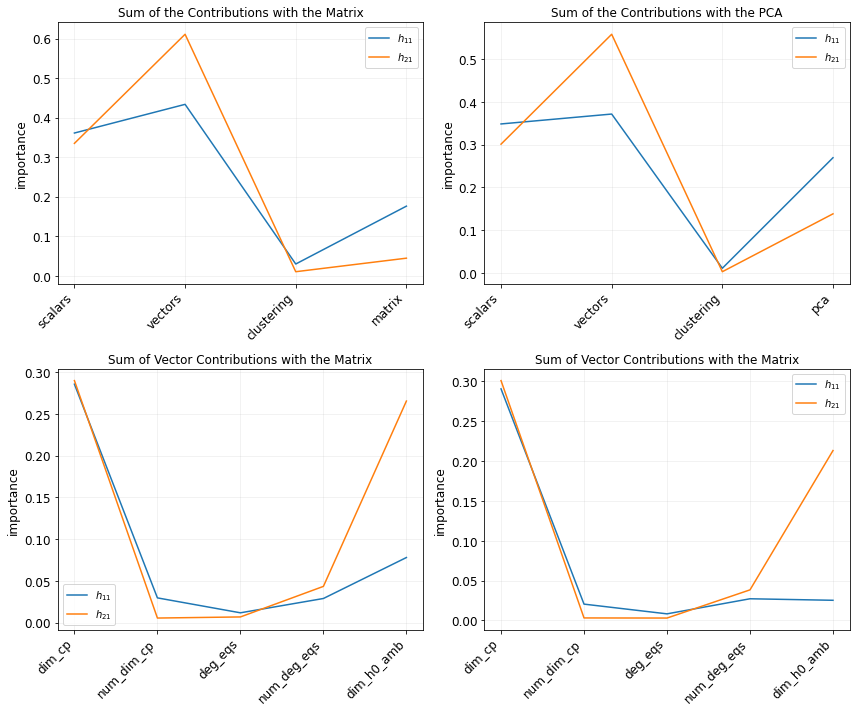

2020-04-24 17:14:04,629: DEBUG ==> Plot saved to ./img/original/feature_importances_sum.pdf.


In [31]:
# sum of the scalar contributions
scalars_sum_mat_h11  = np.sum([i[1] for i in importances_mat_h11[0:np.shape(scalars)[0]]])
scalars_sum_mat_h21  = np.sum([i[1] for i in importances_mat_h21[0:np.shape(scalars)[0]]])
scalars_sum_pca_h11  = np.sum([i[1] for i in importances_pca_h11[0:np.shape(scalars)[0]]])
scalars_sum_pca_h21  = np.sum([i[1] for i in importances_pca_h21[0:np.shape(scalars)[0]]])

# sum of the vector contributions (cumulative)
vectors_sum_mat_h11  = np.sum([i[1] for i in importances_mat_h11[np.shape(scalars)[0]:vector_index]])
vectors_sum_mat_h21  = np.sum([i[1] for i in importances_mat_h21[np.shape(scalars)[0]:vector_index]])
vectors_sum_pca_h11  = np.sum([i[1] for i in importances_pca_h11[np.shape(scalars)[0]:vector_index]])
vectors_sum_pca_h21  = np.sum([i[1] for i in importances_pca_h21[np.shape(scalars)[0]:vector_index]])

# sum of vectors contributions (separate)
vectors_sum_separate_mat_h11 = []
vectors_sum_separate_mat_h21 = []
vectors_sum_separate_pca_h11 = []
vectors_sum_separate_pca_h21 = []

i = 0
for l in ranking_lengths[np.shape(scalars)[0]:]:
    vectors_sum_separate_mat_h11.append(np.sum(vectors_mat_h11[i:i+l]))
    vectors_sum_separate_mat_h21.append(np.sum(vectors_mat_h21[i:i+l]))
    vectors_sum_separate_pca_h11.append(np.sum(vectors_pca_h11[i:i+l]))
    vectors_sum_separate_pca_h21.append(np.sum(vectors_pca_h21[i:i+l]))
    i = i + l

# sum of the cluster contributions
clusters_sum_mat_h11 = np.sum([i[1] for i in importances_mat_h11[vector_index:cluster_index]])
clusters_sum_mat_h21 = np.sum([i[1] for i in importances_mat_h21[vector_index:cluster_index]])
clusters_sum_pca_h11 = np.sum([i[1] for i in importances_pca_h11[vector_index:cluster_index]])
clusters_sum_pca_h21 = np.sum([i[1] for i in importances_pca_h21[vector_index:cluster_index]])

# sum of the matrix and pca contribution
mat_sum_h11          = np.sum([i[1] for i in importances_mat_h11[cluster_index:]])
mat_sum_h21          = np.sum([i[1] for i in importances_mat_h21[cluster_index:]])
pca_sum_h11          = np.sum([i[1] for i in importances_pca_h11[cluster_index:]])
pca_sum_h21          = np.sum([i[1] for i in importances_pca_h21[cluster_index:]])

plot = Plot(rows=2, columns=2)

plot.series2D(data=[scalars_sum_mat_h11, vectors_sum_mat_h11, clusters_sum_mat_h11, mat_sum_h11],
              axis=(0,0),
              title='Sum of the Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{11}$',
              labels=['scalars', 'vectors', 'clustering', 'matrix']
             )
plot.series2D(data=[scalars_sum_mat_h21, vectors_sum_mat_h21, clusters_sum_mat_h21, mat_sum_h21],
              axis=(0,0),
              title='Sum of the Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{21}$',
              labels=['scalars', 'vectors', 'clustering', 'matrix']
             )

plot.series2D(data=[scalars_sum_pca_h11, vectors_sum_pca_h11, clusters_sum_pca_h11, pca_sum_h11],
              axis=(0,1),
              title='Sum of the Contributions with the PCA',
              ylabel='importance',
              legend='$h_{11}$',
              labels=['scalars', 'vectors', 'clustering', 'pca']
             )
plot.series2D(data=[scalars_sum_pca_h21, vectors_sum_pca_h21, clusters_sum_pca_h21, pca_sum_h21],
              axis=(0,1),
              title='Sum of the Contributions with the PCA',
              ylabel='importance',
              legend='$h_{21}$',
              labels=['scalars', 'vectors', 'clustering', 'pca']
             )

plot.series2D(data=vectors_sum_separate_mat_h11,
              axis=(1,0),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{11}$',
              labels=vectors
             )
plot.series2D(data=vectors_sum_separate_mat_h21,
              axis=(1,0),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{21}$',
              labels=vectors
             )

plot.series2D(data=vectors_sum_separate_pca_h11,
              axis=(1,1),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{11}$',
              labels=vectors
             )
plot.series2D(data=vectors_sum_separate_pca_h21,
              axis=(1,1),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{21}$',
              labels=vectors
             )

plot.save_and_close(path.join(IMG_PATH, 'feature_importances_sum'))
log.debug('Plot saved to {}.'.format(path.join(IMG_PATH, 'feature_importances_sum.pdf')))

## Discussion and Feature Selection

From the results of the preanalysis we see that there are indeed features which play a stronger role in predicting the labels. In particular we find that **more correlated** features (see the [correlation matrix](#Correlation-Matrix)) are usually **more relevant** in a decision tree, at least for scalar features. For instance `num_cp` (and `norm_matrix`, even though more marginally and mostly for $h_{11}$ more than $h_{21}$) is a relevant **scalar** feature (see the [feature importances](#Separate-Feature-Visualisation)) for the predictions of both $h_{11}$ and $h_{21}$ and we should certainly select it in the analysis.

The vector features are instead a bit more complicated and dependending on the use of the **configuration matrix** or its **pca**, we get slightly different results: in both cases `dim_cp` is a good marker for the predictions of both Hodge numbers (and we will certainly select it), while `dim_h0_amb` is extremely relevant only for $h_{21}$ (as shown in the [cumulative plots](#Cumulative-Feature_Visualisation)). For $h_{11}$ it gains a bit more relevance when the **configuration matrix** is used.

The [clustering](#K-Means-Clustering) analysis shows that there are no visible or recognizable clusters in the data. In fact even the variable ranking seems to hint to the fact that more clusters usually lead to more relevant features (the final result with 15 clusters for $h_{11}$ is almost equal to a classification task, since the number of clusters almost equals the number of "classes" in the label $h_{11}$, that is the number of clusters spans the entire range of $h_{11}$). Additionally, even choosing the more relevant number of clusters, the _K Means_ analysis does not play a relevant role and should not be considered as a feature for the analysis.

Finally the [PCA](#PCA) certainly contains more relevant information than the matrix itself and it will end up being the final choice, even though we will perform a baseline analysis containing only the matrix for comparison.

In order to avoid introducing personal bias or arbitrariness, we then choose only the features with a variable ranking $\ge 10%$ (for the vector and tensor features this is computed cumulatively, not per entry). We will therefore select the following features, which will then be addressed collectively as the _feature engineered_ set:

- `num_cp`, `dim_cp`, `pca99` for the prediction of $h_{11}$,
- `num_cp`, `dim_cp`, `dim_h0_amb`, `pca99` for the prediction of $h_{21}$.

We will then perform the following analysis:

- a baseline using `matrix` for both $h_{11}$ and $h_{21}$ (both for performance analysis and comparison with [_Bull et al._](https://arxiv.org/abs/1806.03121)),
- a second baseline using the most important feature for both $h_{11}$ and $h_{21}$ (in this case `num_cp`),
- a check using only the engineered features such as `num_cp`, `dim_cp` (and `dim_h0_amb` for $h_{21}$) without `matrix` or `pca99`,
- the complete result using the feature engineered set.

In [32]:
# create a dataframe using the features to be extracted
pd.options.mode.chained_assignment = None #-------------------------------------------------------- allow assignement as in Python dictionaries
df_extracted        = df_shuffled[['h11', 'h21', 'num_cp', 'dim_cp', 'dim_h0_amb', 'matrix']] #---- select features and labels
df_extracted['pca'] = pca99.tolist() #------------------------------------------------------------- add pca column (needs .tolist() to be inserted)

# save new database to file
df_extracted.to_hdf(path.join(ROOT_DIR, DB_NAME + '_analysis.h5'),
                    key=DB_NAME,
                    mode='w',
                    complevel=9,
                    complib='bzip2'
                   )
log.debug('New database saved to {}.'.format(path.join(ROOT_DIR, DB_NAME + '_analysis.h5')))

/home/riccardo/anaconda/envs/ml/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->Index(['dim_cp', 'dim_h0_amb', 'matrix', 'pca'], dtype='object')]

  encoding=encoding,
2020-04-24 17:14:04,969: DEBUG ==> New database saved to ./cicy3o_analysis.h5.
